# 분석 환경 세팅

In [54]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [13]:
## 셀에서 값을 모두 출력
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Image

In [14]:
## 설정
# 지수표기법 대신 숫자표기법
pd.options.display.float_format = '{:.2f}'.format

# 스타일
plt.style.use('seaborn-v0_8-darkgrid')

# 폰트
from matplotlib import font_manager
# - 맑은고딕 보통과 굵은 글꼴 경로
font_path_regular = "C:/Windows/Fonts/malgun.ttf"  # 맑은고딕 보통
font_path_bold = "C:/Windows/Fonts/malgunbd.ttf"  # 맑은고딕 굵게

# - 폰트 추가
font_manager.fontManager.addfont(font_path_regular)
font_manager.fontManager.addfont(font_path_bold)

# - 기본 폰트 설정 (맑은고딕 보통을 기본 폰트로 설정)
plt.rc('font', family='Malgun Gothic')  # 기본 폰트는 보통

# - 음수 부호 표시 설정
plt.rcParams['axes.unicode_minus'] = False  # 음수 부호 제대로 표시

# 데이터 프레임의 모든 레코드 출력
def print_all(obj, n=None):
    pd.set_option('display.max_row', n)
    display(obj)
    pd.set_option('display.max_row', 10)

# 모든 칼럼 출력
pd.set_option('display.max_columns', None)

In [15]:
custom_palette = [
    'tomato', 'royalblue', 'mediumseagreen', 'goldenrod', 'orchid', 
    'slategray', 'dodgerblue', 'darkorange', 'turquoise', 'firebrick', 'mediumvioletred'
]

# 데이터 로드 및 전처리

In [ ]:
con = duckdb.connect()

# 파일 경로들
files = [
    '데이터/2019-Oct.parquet',   # 또는 .parquet
    '데이터/2019-Nov.parquet'
]

# 파일 1 + 2 병합하여 이벤트 테이블 생성
con.execute(f"""
    CREATE OR REPLACE TABLE events AS
    SELECT 
        user_id,
        event_time::TIMESTAMP AS event_time,
        event_type,
        product_id,
        category_code,
        brand,
        price
    FROM read_parquet('{files[0]}')
    WHERE event_type IN ('view', 'cart', 'purchase') 
      AND price IS NOT NULL 
      AND price > 0

""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [3]:
con.execute("""
    CREATE OR REPLACE TABLE events_clean AS
    SELECT *
    FROM events
    WHERE event_time IS NOT NULL
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [4]:
# 세션 정의
con.execute("""
    CREATE OR REPLACE TABLE events_with_session AS
    SELECT *,
        SUM(session_split_flag) OVER (
            PARTITION BY user_id 
            ORDER BY event_time
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS session_id
    FROM (
        SELECT *,
            CASE 
                WHEN event_time - LAG(event_time) 
                    OVER (PARTITION BY user_id ORDER BY event_time) > INTERVAL '30 minutes' 
                THEN 1 
                ELSE 0 
            END AS session_split_flag
        FROM events_clean
        WHERE event_time IS NOT NULL  -- 추가 안전장치
    )
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
# 세션 단위 집계
df = con.execute("""
    SELECT 
        user_id,
        session_id,
        MIN(event_time) AS session_start,
        MAX(event_time) AS session_end,

        CAST((EPOCH(MAX(event_time)) - EPOCH(MIN(event_time))) / 60 AS INTEGER) AS session_length,
        COUNT(*) AS total_events,
        COUNT(DISTINCT event_type) AS event_diversity,

        SUM(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END) AS n_view,
        SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) AS n_cart,
        SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) AS n_purchase,

        COUNT(DISTINCT brand) AS unique_brands,
        COUNT(brand) - COUNT(DISTINCT brand) AS brand_repeat_count,

        AVG(price) AS avg_price,
        EXTRACT(HOUR FROM MIN(event_time)) AS hour_of_day,
        EXTRACT(DOW FROM MIN(event_time)) AS day_of_week,

        COUNT(DISTINCT category_code) AS category_diversity,
        MODE() WITHIN GROUP (ORDER BY category_code) AS dominant_category,
        SPLIT_PART(MODE() WITHIN GROUP (ORDER BY category_code), '.', 1) AS main_category,
        SPLIT_PART(MODE() WITHIN GROUP (ORDER BY category_code), '.', 2) AS sub_category,

        CASE 
            WHEN SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) > 0 THEN 1 
            ELSE 0 
        END AS converted

    FROM events_with_session
    GROUP BY user_id, session_id
""").fetchdf()



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
# DataFrame을 parquet 파일로 저장
df.to_parquet("데이터/ecommerce_sessions_df_oct.parquet", index=False)

In [ ]:
df = pd.read_parquet('데이터\분할\sessions_summary-merged.parquet')

# 1. 퍼널 분석

In [9]:
# 전체 Funnel 전환율 계산
total_sessions = len(df)
n_view_only = df.query("n_view > 0 and n_cart == 0 and n_purchase == 0").shape[0]
n_cart = df.query("n_cart > 0").shape[0]
n_purchase = df.query("n_purchase > 0").shape[0]

view_to_cart = n_cart / total_sessions
cart_to_purchase = df.query("n_cart > 0 and n_purchase > 0").shape[0] / n_cart
view_to_purchase = n_purchase / total_sessions

print(f"View → Cart 전환율: {view_to_cart:.2%}")
print(f"Cart → Purchase 전환율: {cart_to_purchase:.2%}")
print(f"View → Purchase 전환율: {view_to_purchase:.2%}")


View → Cart 전환율: 10.71%
Cart → Purchase 전환율: 40.29%
View → Purchase 전환율: 6.39%


In [27]:
# Main 카테고리별 전환율 계산
main_category_funnel = (
    df.groupby("main_category")
      .agg(total_sessions=("session_id", "count"),
           purchase_sessions=("converted", "sum"))
      .assign(view_to_purchase_rate=lambda x: x["purchase_sessions"] / x["total_sessions"])
      .sort_values("view_to_purchase_rate", ascending=False)
)

print(main_category_funnel.head(10))
main_category_funnel.to_clipboard()

               total_sessions  purchase_sessions  view_to_purchase_rate
main_category                                                          
appliances            1794224             123007                   0.07
electronics           2004919             131701                   0.07
computers              841180              41988                   0.05


In [28]:
# Sub 카테고리별 전환율 계산
sub_category_funnel = (
    df.groupby(["main_category", "sub_category"])
      .agg(total_sessions=("session_id", "count"),
           purchase_sessions=("converted", "sum"))
      .assign(view_to_purchase_rate=lambda x: x["purchase_sessions"] / x["total_sessions"])
      .sort_values("view_to_purchase_rate", ascending=False)
)

print(sub_category_funnel.head(10))
sub_category_funnel.to_clipboard()

                             total_sessions  purchase_sessions  \
main_category sub_category                                       
appliances    iron                    63049               5723   
              ironing_board           12049                940   
              personal                54952               4257   
              environment            433206              32059   
electronics   video                  475095              35045   
              telephone               75573               5538   
              audio                  747005              54307   
appliances    kitchen               1169980              76532   
electronics   tablet                 126377               7720   
computers     notebook               398692              23140   

                             view_to_purchase_rate  
main_category sub_category                          
appliances    iron                            0.09  
              ironing_board                   0.

<Figure size 600x400 with 0 Axes>

<Axes: xlabel='hour_of_day', ylabel='view_to_purchase_rate'>

Text(0.5, 1.0, '시간대별 View → Purchase 전환율')

Text(0.5, 0, '시간대 (시)')

Text(0, 0.5, '전환율')

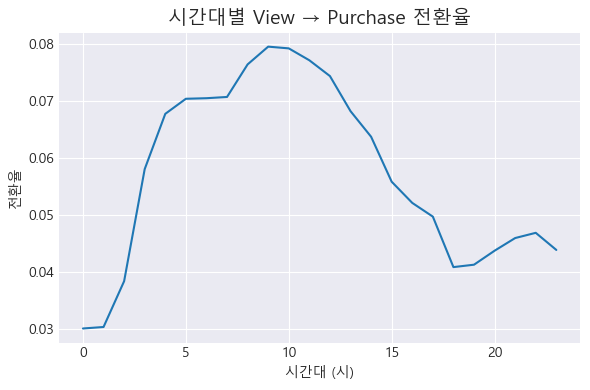

In [29]:
# 시간대별 전환율
hourly_funnel = (
    df.groupby("hour_of_day")
      .agg(total_sessions=("session_id", "count"),
           purchases=("converted", "sum"))
      .assign(view_to_purchase_rate=lambda x: x["purchases"] / x["total_sessions"])
)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.lineplot(data=hourly_funnel, x=hourly_funnel.index, y="view_to_purchase_rate")
plt.title("시간대별 View → Purchase 전환율", fontsize=14)
plt.xlabel("시간대 (시)")
plt.ylabel("전환율")
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
# 가격대별 전환율
bins = [0, 50, 100, 200, 500, df['avg_price'].max()]
labels = ['~$50', '$50~$100', '$100~$200', '$200~$500', '$500~']
df["price_bin"] = pd.cut(df["avg_price"], bins=bins, labels=labels, include_lowest=True)

price_funnel = (
    df.groupby("price_bin")
      .agg(total_sessions=("session_id", "count"),
           purchases=("converted", "sum"))
      .assign(view_to_purchase_rate=lambda x: x["purchases"] / x["total_sessions"])
)

print(price_funnel)
price_funnel.to_clipboard()

           total_sessions  purchases  view_to_purchase_rate
price_bin                                                  
~$50               591020      43829                   0.07
$50~$100           595720      40587                   0.07
$100~$200         1063957      79432                   0.07
$200~$500         1590291     101005                   0.06
$500~              799335      31843                   0.04


C:\Users\sangw\AppData\Local\Temp\ipykernel_20964\2352703574.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("price_bin")


<Figure size 600x400 with 0 Axes>

<Axes: >

(0.0, 0.48351383003126996)

Text(0, 0.5, '전환율')

Text(0.5, 1.0, '전체 Funnel 전환율')

Text(0, 0.11709642410668394, '10.7%')

Text(1, 0.412928191692725, '40.3%')

Text(2, 0.07393865254638524, '6.4%')

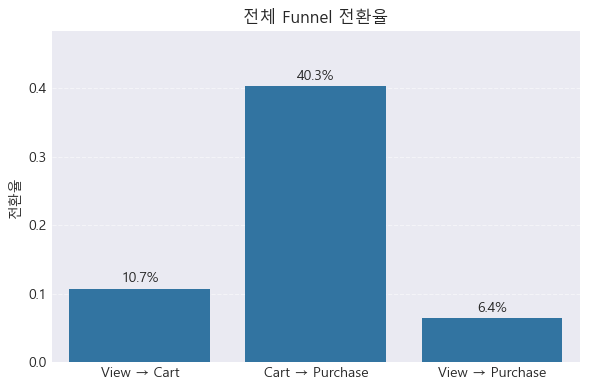

In [24]:
funnel_values = [view_to_cart, cart_to_purchase, view_to_purchase]
funnel_labels = ["View → Cart", "Cart → Purchase", "View → Purchase"]

plt.figure(figsize=(6, 4))
sns.barplot(x=funnel_labels, y=funnel_values)
plt.ylim(0, max(funnel_values)*1.2)
plt.ylabel("전환율")
plt.title("전체 Funnel 전환율")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
for i, v in enumerate(funnel_values):
    plt.text(i, v + 0.01, f"{v:.1%}", ha='center')
plt.tight_layout()
plt.show()

  weekday_name  view_to_purchase_rate
0            일                   0.10
1            월                   0.05
2            화                   0.06
3            수                   0.06
4            목                   0.07
5            금                   0.05
6            토                   0.06


<Figure size 800x400 with 0 Axes>

<Axes: xlabel='weekday_name', ylabel='view_to_purchase_rate'>

Text(0.5, 1.0, '요일별 View → Purchase 전환율')

Text(0, 0.5, '전환율')

Text(0.5, 0, '요일')

(0.0, 0.12142720958066155)

Text(0, 0.10218934131721796, '10.1%')

Text(1, 0.05071954988627711, '5.0%')

Text(2, 0.056825981965126775, '5.6%')

Text(3, 0.059090100340082045, '5.8%')

Text(4, 0.0699447974273665, '6.9%')

Text(5, 0.048395950719547276, '4.7%')

Text(6, 0.06382534015391308, '6.3%')

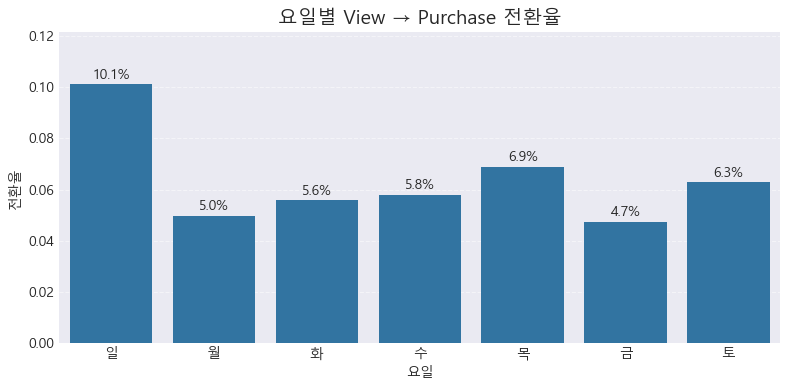

In [34]:
# 요일 이름 맵핑 (0 = Monday, 6 = Sunday)
weekday_labels = ['일', '월', '화', '수', '목', '금', '토']

# 요일별 전환율 집계
weekday_funnel = (
    df.groupby("day_of_week")
      .agg(total_sessions=("session_id", "count"),
           purchases=("converted", "sum"))
      .assign(view_to_purchase_rate=lambda x: x["purchases"] / x["total_sessions"])
      .rename_axis("weekday")
      .reset_index()
)

# 요일 이름 맵핑
weekday_funnel["weekday_name"] = weekday_funnel["weekday"].map(dict(zip(range(7), weekday_labels)))

# 정렬 순서 보장
weekday_funnel = weekday_funnel.sort_values("weekday")

# 결과 출력
print(weekday_funnel[["weekday_name", "view_to_purchase_rate"]])

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.barplot(data=weekday_funnel, x="weekday_name", y="view_to_purchase_rate")
plt.title("요일별 View → Purchase 전환율", fontsize=14)
plt.ylabel("전환율")
plt.xlabel("요일")
plt.ylim(0, weekday_funnel["view_to_purchase_rate"].max() * 1.2)
plt.grid(axis="y", linestyle="--", alpha=0.5)
for i, v in enumerate(weekday_funnel["view_to_purchase_rate"]):
    plt.text(i, v + 0.001, f"{v:.1%}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

# 2. 세션 기반 행동 분석

In [36]:
df.head()

,user_id,session_id,session_start,session_end,session_length,total_events,event_diversity,n_view,n_cart,n_purchase,unique_brands,brand_repeat_count,avg_price,hour_of_day,day_of_week,category_diversity,dominant_category,main_category,sub_category,converted,price_bin
0,516779694,0.00,2019-10-03 17:15:58,2019-10-03 17:15:58,0,1,1,1.00,0.00,0.00,1,0,460.76,17,4,1,electronics.video.tv,electronics,video,0,$200~$500
1,516818999,1.00,2019-10-02 10:07:32,2019-10-02 10:18:19,11,3,1,3.00,0.00,0.00,1,2,150.58,10,3,1,electronics.video.tv,electronics,video,0,$100~$200
2,516871171,0.00,2019-10-02 01:28:46,2019-10-02 01:29:18,1,2,1,2.00,0.00,0.00,1,1,83.35,1,3,1,appliances.environment.water_heater,appliances,environment,0,$50~$100
3,517086587,1.00,2019-10-01 10:35:58,2019-10-01 10:45:09,9,11,1,11.00,0.00,0.00,0,0,191.34,10,2,1,appliances.kitchen.refrigerators,appliances,kitchen,0,$100~$200
4,517330510,0.00,2019-10-04 06:23:26,2019-10-04 06:28:30,5,5,1,5.00,0.00,0.00,5,0,56.99,6,5,3,appliances.kitchen.microwave,appliances,kitchen,0,$50~$100


session_length, n_view, n_cart, unique_brands, avg_price

In [40]:
# 분석 대상 변수
features = ["session_length", "n_view", "n_cart", "unique_brands", "avg_price"]

# 전환 여부 기준 그룹 나누기
success = df[df['converted'] == 1]
fail = df[df['converted'] == 0]

# 평균 비교 테이블 생성
comparison = pd.DataFrame({
    "구매 세션 평균": success[features].mean(),
    "미구매 세션 평균": fail[features].mean()
}).round(2)

comparison
comparison.to_clipboard()

,구매 세션 평균,미구매 세션 평균
session_length,14.58,6.04
n_view,8.63,5.41
n_cart,1.38,0.12
unique_brands,2.18,2.00
avg_price,248.72,316.46


<Figure size 600x400 with 0 Axes>

<Axes: xlabel='converted', ylabel='session_length'>

Text(0.5, 1.0, 'session_length vs 전환 여부')

Text(0.5, 0, '전환 여부')

Text(0, 0.5, 'session_length')

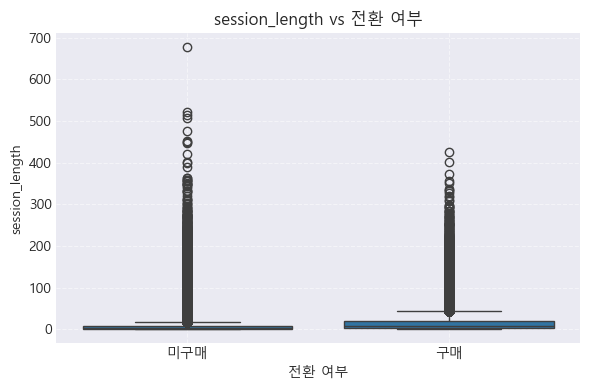

<Figure size 600x400 with 0 Axes>

<Axes: xlabel='converted', ylabel='n_view'>

Text(0.5, 1.0, 'n_view vs 전환 여부')

Text(0.5, 0, '전환 여부')

Text(0, 0.5, 'n_view')

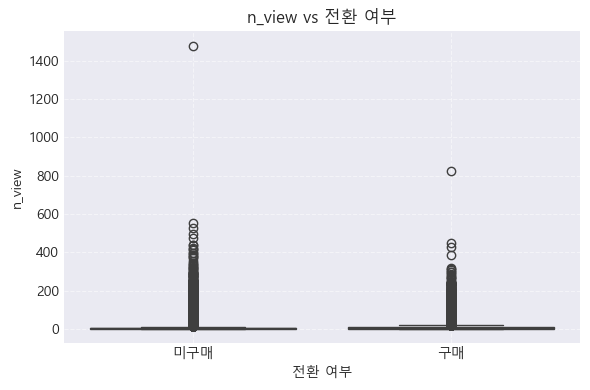

<Figure size 600x400 with 0 Axes>

<Axes: xlabel='converted', ylabel='n_cart'>

Text(0.5, 1.0, 'n_cart vs 전환 여부')

Text(0.5, 0, '전환 여부')

Text(0, 0.5, 'n_cart')

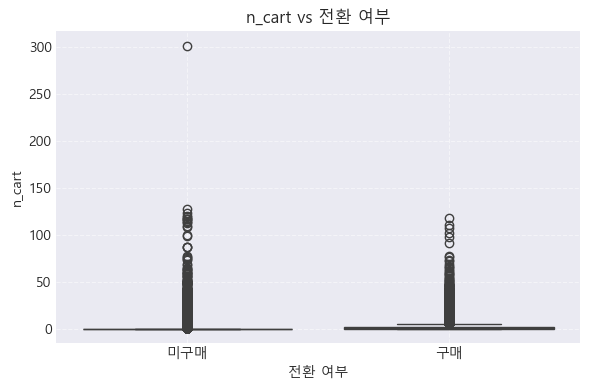

<Figure size 600x400 with 0 Axes>

<Axes: xlabel='converted', ylabel='unique_brands'>

Text(0.5, 1.0, 'unique_brands vs 전환 여부')

Text(0.5, 0, '전환 여부')

Text(0, 0.5, 'unique_brands')

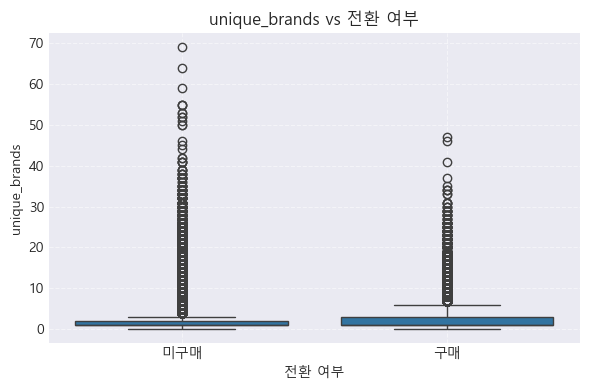

<Figure size 600x400 with 0 Axes>

<Axes: xlabel='converted', ylabel='avg_price'>

Text(0.5, 1.0, 'avg_price vs 전환 여부')

Text(0.5, 0, '전환 여부')

Text(0, 0.5, 'avg_price')

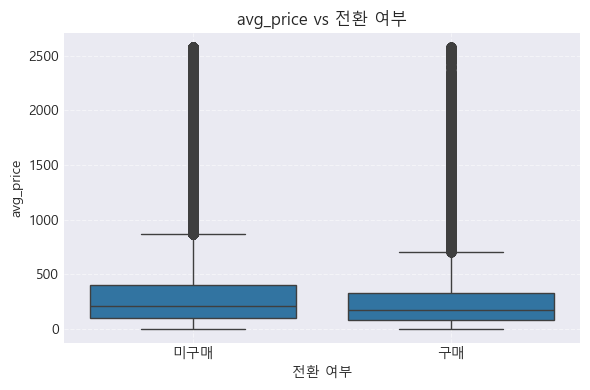

In [38]:
# long-form 데이터 변환
plot_df = df[df["converted"].isin([0, 1])][features + ["converted"]].copy()
plot_df["converted"] = plot_df["converted"].map({0: "미구매", 1: "구매"})

# 변수별 boxplot
for var in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=plot_df, x="converted", y=var)
    plt.title(f"{var} vs 전환 여부")
    plt.xlabel("전환 여부")
    plt.ylabel(var)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# 3. 전환 예측 모델링

In [42]:
# 1. 변수 구성
numerical_features = ["session_length", "n_view", "n_cart", "avg_price"]
categorical_features = ["hour_of_day", "day_of_week", "main_category", "sub_category"]
target = "converted"

X = df[numerical_features + categorical_features]
y = df[target]

In [43]:
# 2. 전처리 파이프라인
preprocessor = ColumnTransformer([
    ("num", "passthrough", numerical_features),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [44]:
# 3. 모델 파이프라인 구성
model_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

In [45]:
# 4. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# 5. 모델 학습 및 예측
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
y_prob = model_pipeline.predict_proba(X_test)[:, 1]

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['session_length', 'n_view',
                                                   'n_cart', 'avg_price']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hour_of_day', 'day_of_week',
                                                   'main_category',
                                                   'sub_category'])])),
                ('clf', LogisticRegression(max_iter=1000))])

In [47]:
# 6. 평가 결과 출력
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.94      0.99      0.97    868695
           1       0.54      0.13      0.20     59370

    accuracy                           0.94    928065
   macro avg       0.74      0.56      0.59    928065
weighted avg       0.92      0.94      0.92    928065

ROC AUC Score: 0.8434


<Figure size 900x600 with 0 Axes>

C:\Users\sangw\AppData\Local\Temp\ipykernel_20964\3104204918.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df.head(20), x="Coefficient", y="Feature", palette="crest")


<Axes: xlabel='Coefficient', ylabel='Feature'>

Text(0.5, 1.0, '전환 예측 모델 Feature Importance (상위 20개)')

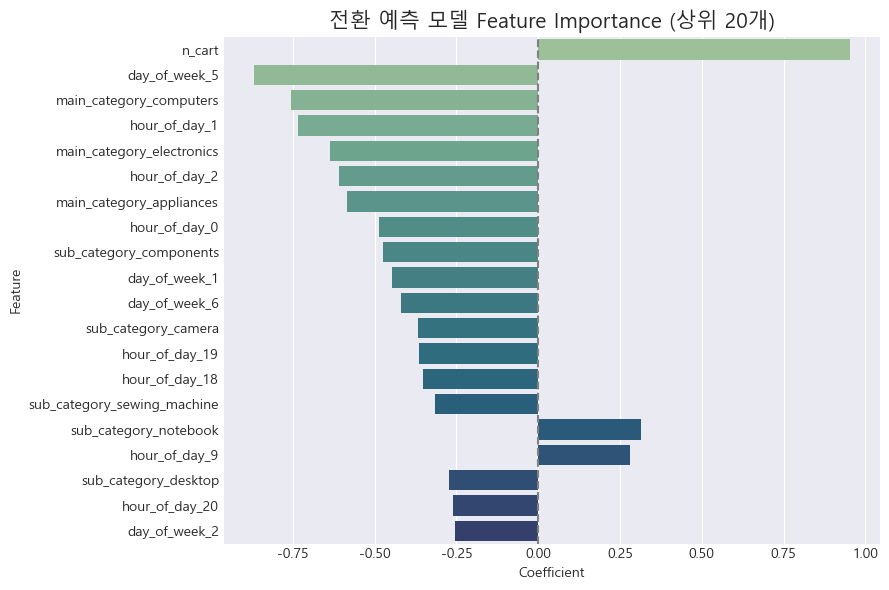

,Feature,Coefficient,Abs_Coefficient
2,n_cart,0.95,0.95
33,day_of_week_5,-0.87,0.87
36,main_category_computers,-0.76,0.76
5,hour_of_day_1,-0.73,0.73
37,main_category_electronics,-0.64,0.64
6,hour_of_day_2,-0.61,0.61
35,main_category_appliances,-0.58,0.58
4,hour_of_day_0,-0.49,0.49
41,sub_category_components,-0.47,0.47
29,day_of_week_1,-0.45,0.45


In [52]:
# 변수 이름 정리
feature_names_num = numerical_features
feature_names_cat = model_pipeline.named_steps["preprocess"].transformers_[1][1].get_feature_names_out(categorical_features)
feature_names_all = np.concatenate([feature_names_num, feature_names_cat])

# 계수 추출
coefs = model_pipeline.named_steps["clf"].coef_[0]
coef_df = pd.DataFrame({
    "Feature": feature_names_all,
    "Coefficient": coefs,
    "Abs_Coefficient": np.abs(coefs)
}).sort_values("Abs_Coefficient", ascending=False)

# 시각화 (절댓값 기준 상위 20개)
plt.figure(figsize=(9, 6))
sns.barplot(data=coef_df.head(20), x="Coefficient", y="Feature", palette="crest")
plt.axvline(0, color="gray", linestyle="--")
plt.title("전환 예측 모델 Feature Importance (상위 20개)", fontsize=15)
plt.tight_layout()
plt.show()

# 상위 결과 확인
display(coef_df)

In [1]:
import plotly.graph_objects as go

# 단계별 명칭과 전환율 값
stages = ["View", "Cart", "Purchase"]
conversion_values = [100, 10.71, 6.39]  # View를 100으로 가정하고 비율 적용

fig = go.Figure(go.Funnel(
    y=stages,
    x=conversion_values,
    textinfo="value+percent previous+percent total"
))

fig.update_layout(title="퍼널 분석 시각화 (View → Cart → Purchase)")
fig.show()

C:\Users\sangw\AppData\Local\Temp\ipykernel_7336\1306424360.py:21: UserWarning:

Glyph 54140 (\N{HANGUL SYLLABLE PEO}) missing from current font.

C:\Users\sangw\AppData\Local\Temp\ipykernel_7336\1306424360.py:21: UserWarning:

Glyph 45328 (\N{HANGUL SYLLABLE NEOL}) missing from current font.

C:\Users\sangw\AppData\Local\Temp\ipykernel_7336\1306424360.py:21: UserWarning:

Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.

C:\Users\sangw\AppData\Local\Temp\ipykernel_7336\1306424360.py:21: UserWarning:

Glyph 49437 (\N{HANGUL SYLLABLE SEOG}) missing from current font.

d:\Coding\envs\sw_basic_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 54140 (\N{HANGUL SYLLABLE PEO}) missing from current font.

d:\Coding\envs\sw_basic_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 45328 (\N{HANGUL SYLLABLE NEOL}) missing from current font.

d:\Coding\envs\sw_basic_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

G

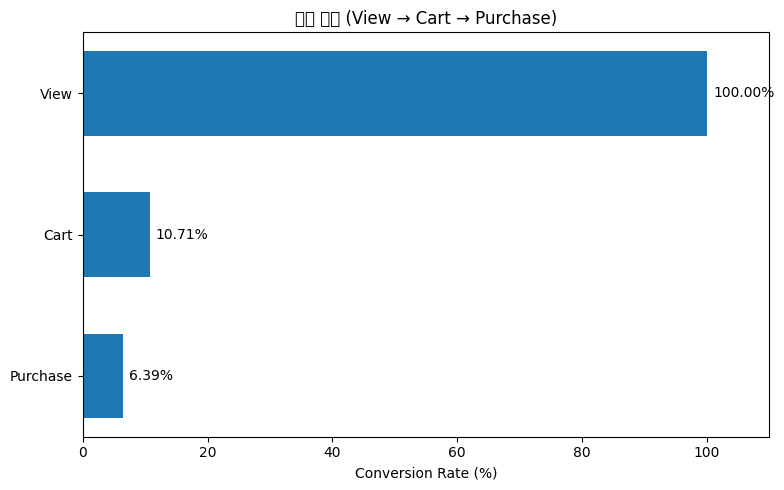

In [2]:
import matplotlib.pyplot as plt

# 단계 및 값 정의
stages = ['View', 'Cart', 'Purchase']
conversion_values = [100, 10.71, 6.39]  # View를 100으로 기준

# 색상 및 도형 설정
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(stages[::-1], conversion_values[::-1], height=0.6)

# 막대에 값 표시
for bar in bars:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
            f'{width:.2f}%', va='center')

# 스타일 및 제목
ax.set_xlim(0, 110)
ax.set_xlabel('Conversion Rate (%)')
ax.set_title('퍼널 분석 (View → Cart → Purchase)')
plt.tight_layout()
plt.show()
